In [134]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
import os
cur_dir = "/content/drive/MyDrive/mid-term"
os.chdir(cur_dir)
!ls -la .

total 265253
-rw------- 1 root root    337117 Dec 25 21:56 baseline2.ipynb
drwx------ 2 root root      4096 Dec 26 16:34 data
-rw------- 1 root root  30110922 Dec 18 00:59 fer2013_publictest_onehot.csv
-rw------- 1 root root 240958308 Dec 18 16:00 fer2013_training_onehot.csv
-rw------- 1 root root    207826 Dec 26 16:34 model.png


In [136]:
import zipfile

with zipfile.ZipFile('data/data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Overview
- FER2013 dataset (face images + facial expression)
  + Goal: classifying facial exprression
  + Input: a 48x48 image
  + Output: facial expression (angry, disgust, fear, happy, neutral, sad, and surprise)
- Defining an CNN+MLP
- Training and evaluating an CNN+MLP

# Import libraries

In [157]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

from IPython.display import SVG
from tensorflow.keras.utils import plot_model

import time
import numpy as np
import matplotlib.pyplot as plt

In [138]:
num_classes = 7   # angry, disgust, fear, happy, neutral, sad, and surprise

In [139]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# (1) Data

### Download data at https://www.kaggle.com/datasets/dntai1983/fer2013-onehot
This source code and npy files MUST be in the same location

In [140]:
n_inputs = 2304
n_classes = 7
img_dim = 48

trainingset = np.loadtxt('fer2013_training_onehot.csv', delimiter=',')
testingset = np.loadtxt('fer2013_publictest_onehot.csv', delimiter=',')

trainingset

array([[ 70.,  80.,  82., ...,   0.,   0.,   0.],
       [151., 150., 147., ...,   0.,   0.,   0.],
       [231., 212., 156., ...,   0.,   0.,   0.],
       ...,
       [ 74.,  81.,  87., ...,   1.,   0.,   0.],
       [222., 227., 203., ...,   0.,   0.,   0.],
       [195., 199., 205., ...,   1.,   0.,   0.]])

In [141]:

x_training = trainingset[:, 0:n_inputs]
y_training = trainingset[:, n_inputs:n_inputs + n_classes]

x_testing = testingset[:, 0:n_inputs]
y_testing = testingset[:, n_inputs:n_inputs + n_classes]

In [142]:
print("Training images: ", len(x_training), " - shape: ", x_training[0].shape)
print("Testing images: ", len(x_testing), " - shape: ", x_testing[0].shape)

Training images:  28709  - shape:  (2304,)
Testing images:  3589  - shape:  (2304,)


In [143]:
x_training.shape, y_training.shape

((28709, 2304), (28709, 7))

In [144]:
display(x_training[:3, :])
display(y_training[:3, :], np.argmax(y_training[:3, :], axis=1))

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.]])

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]])

array([0, 0, 2])

In [145]:
x_training = x_training.reshape(x_training.shape[0], 48, 48)
display(x_training.shape)
x_training = np.expand_dims(x_training, axis=3)
display(x_training.shape)

x_testing = x_testing.reshape(x_testing.shape[0], 48, 48)
display(x_testing.shape)
x_testing = np.expand_dims(x_testing, axis=3)
display(x_testing.shape)

(28709, 48, 48)

(28709, 48, 48, 1)

(3589, 48, 48)

(3589, 48, 48, 1)

In [146]:
y_train_labels = np.argmax(y_training, axis = 1)

In [147]:
emotion_names = np.array(["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"])

In [148]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

<BarContainer object of 7 artists>

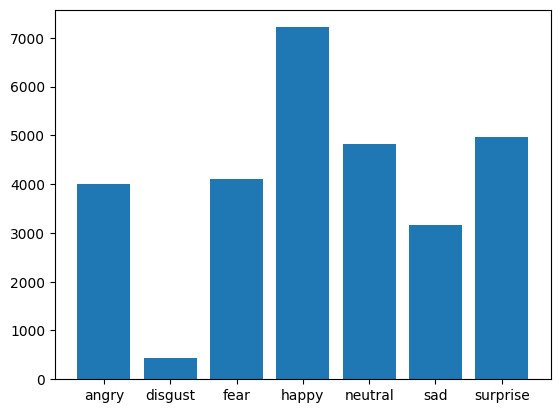

In [149]:
labels, cnts = np.unique(y_train_labels, return_counts=True)
plt.bar(emotion_names, cnts)

In [150]:
from sklearn.utils import class_weight

In [151]:
y_train_labels

array([0, 0, 2, ..., 4, 0, 4])

In [152]:
cnts / sum(cnts)

array([0.13915497, 0.01518688, 0.14270786, 0.25131492, 0.16823992,
       0.11045317, 0.17294228])

In [153]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=labels,
                                            y=y_train_labels)
weights

array([1.02660468, 9.40661861, 1.00104606, 0.56843877, 0.84912748,
       1.29337298, 0.82603942])

# (2) Declare model

In [154]:
from tensorflow.keras import layers, models

# Define the input layer
input_layer = layers.Input(shape=(48, 48, 1), name='input')

# Convolutional Blocks
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_layer)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = layers.MaxPooling2D((2, 2), name='block2_pool')(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = layers.MaxPooling2D((2, 2), name='block3_pool')(x)

x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = layers.MaxPooling2D((2, 2), name='block4_pool')(x)

x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = layers.MaxPooling2D((2, 2), name='block5_pool')(x)

# Global Average Pooling Layer
x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)

# Dropout Layers
x = layers.Dropout(0.5, name='dropout_8')(x)

# Fully Connected Layers
x = layers.Dense(2048, activation='relu', name='dense_4')(x)
x = layers.Dropout(0.5, name='dropout_9')(x)

# Output Layer
output_layer = layers.Dense(7, activation='softmax', name='predictions')(x)

# Create the model
model = models.Model(inputs=input_layer, outputs=output_layer)

# Display the model summary
model.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0  

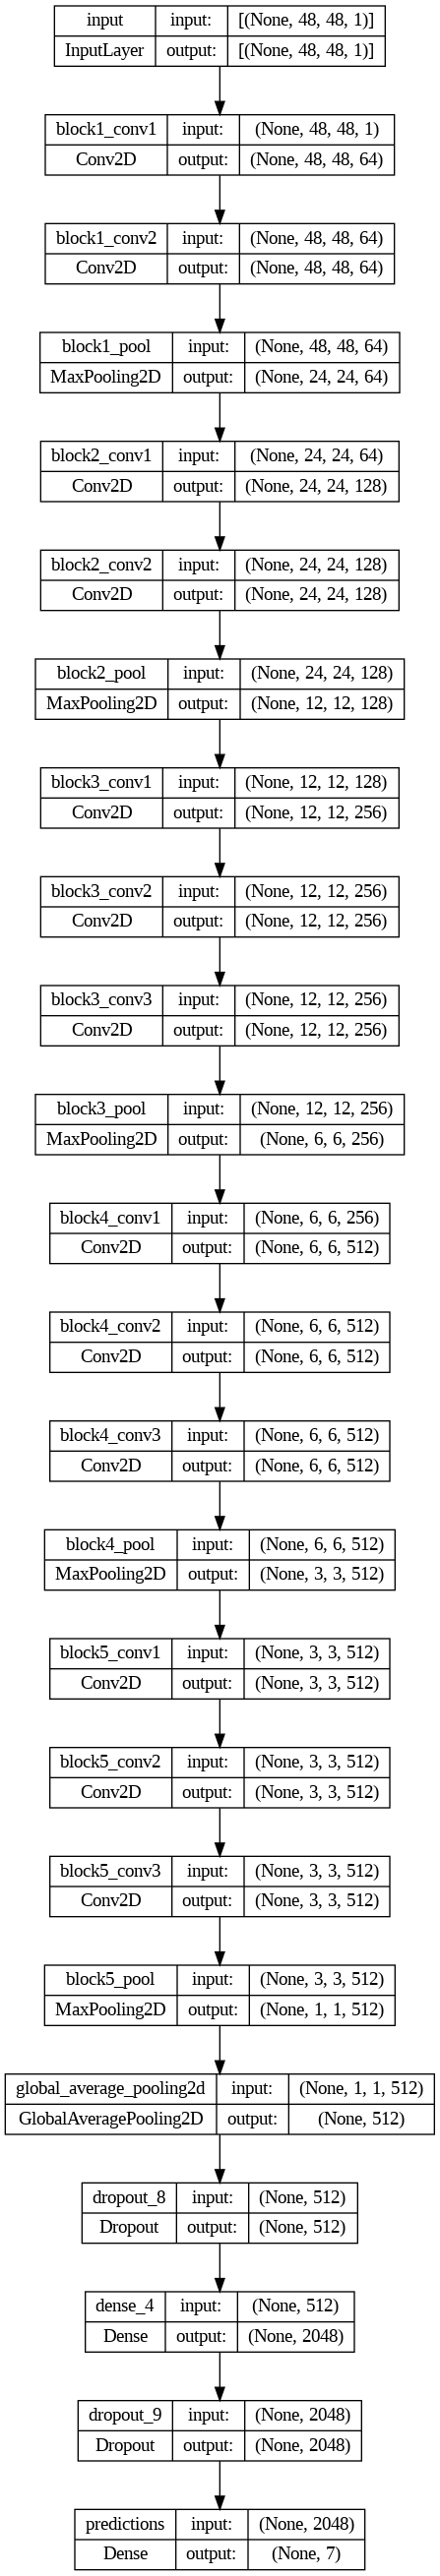

In [155]:
plot_model(model, to_file="model.png", show_shapes=True)

# (3) Train defined model
- Note that the training history including loss and accuracy will be save in 'history' variable
- In case your system runs out of memory (OOM), try to decrease batch size

### **Training Run**

---
with learning_rate = 0.00001


In [161]:
# declare learning rate, loss function, and model metric
loss = 'categorical_crossentropy'
lr = 0.0002
model.compile(loss=loss, optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

In [162]:
# train the model
batch_size = 128
epochs = 15

starting_time = time.time()
h1 = model.fit(x_training, y_training,
                    validation_data=(x_testing, y_testing),
                    batch_size=batch_size,
                    epochs=epochs)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/15
225/225 [==============================] - 28s 101ms/step - loss: 1.8077 - accuracy: 0.2550 - val_loss: 1.6865 - val_accuracy: 0.3171
Epoch 2/15
225/225 [==============================] - 23s 101ms/step - loss: 1.6022 - accuracy: 0.3553 - val_loss: 1.4636 - val_accuracy: 0.4296
Epoch 3/15
225/225 [==============================] - 23s 102ms/step - loss: 1.4217 - accuracy: 0.4425 - val_loss: 1.3273 - val_accuracy: 0.4834
Epoch 4/15
225/225 [==============================] - 23s 104ms/step - loss: 1.2840 - accuracy: 0.5023 - val_loss: 1.2466 - val_accuracy: 0.5104
Epoch 5/15
225/225 [==============================] - 23s 104ms/step - loss: 1.1675 - accuracy: 0.5522 - val_loss: 1.2598 - val_accuracy: 0.5149
Epoch 6/15
225/225 [==============================] - 24s 105ms/step - loss: 1.0730 - accuracy: 0.5895 - val_loss: 1.1553 - val_accuracy: 0.5567
Epoch 7/15
225/225 [==============================] - 23s 103ms/step - loss: 0.9535 - accuracy: 0.6433 - val_loss: 1.1506 - val_ac

### **Result of The Training Run**

In [163]:
print("Training Run:")
print("Accuracy of the Testing Set: %.2f%%" % (h1.history['val_accuracy'][14]*100))

Training Run:
Accuracy of the Testing Set: 59.65%


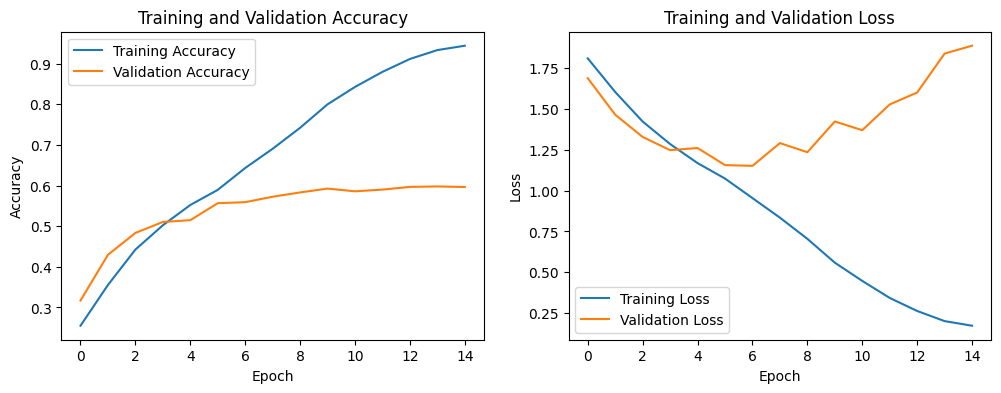

In [164]:
plot_history(h1)

In [165]:
import pandas as pd
pd.DataFrame(h1.history)

,loss,accuracy,val_loss,val_accuracy
0,1.807706,0.255007,1.686505,0.317080
1,1.602229,0.355324,1.463594,0.429646
2,1.421654,0.442509,1.327304,0.483422
3,1.283983,0.502281,1.246616,0.510449
4,1.167519,0.552231,1.259808,0.514907
5,1.072981,0.589502,1.155307,0.556701
6,0.953519,0.643317,1.150620,0.559209
7,0.833993,0.690689,1.289891,0.572583
8,0.704439,0.742311,1.234038,0.583171
9,0.558839,0.800098,1.421844,0.592644


### **Training time**
- Training time is about 6.4435 minutes for 15 epochs

# (4) Evaluate trained model

In [166]:
score = model.evaluate(x_testing, y_testing)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

113/113 [==============================] - 1s 12ms/step - loss: 1.8852 - accuracy: 0.5965
Test loss: 1.8851654529571533
Test accuracy: 0.5965449810028076


In [167]:
def get_emotion(ohv):
    indx = np.argmax(ohv)

    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

1/1 [==============================] - 0s 158ms/step


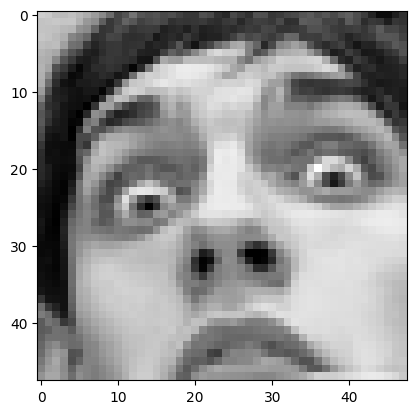

> testing image index: 3423
> true emotion: surprise
> predicted emotion: surprise


In [168]:
# 2163
img_indx = np.uint32(np.random.rand()*(testingset.shape[0] - 1))
sample = x_testing[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_testing[img_indx, :]), get_emotion(pred_cls)))

In [169]:
def predict_image(img_indx):
  sample = x_testing[img_indx, :]
  sample = sample.reshape(48, 48)

  pred_cls = model.predict(sample.reshape(1, 48, 48, 1))

  plt.imshow(sample, cmap='gray')
  plt.show()
  print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_testing[img_indx, :]), get_emotion(pred_cls)))

In [170]:
y_test_pred = model.predict(x_testing)

113/113 [==============================] - 1s 11ms/step


In [171]:
y_test_pred_label = np.argmax(y_test_pred, axis = 1)
y_test_label = np.argmax(y_testing, axis=1)

**10 cases of incorrect predictions**

---

In [172]:
np.where(y_test_pred_label != y_test_label)

(array([   1,    2,    3, ..., 3584, 3587, 3588]),)

1/1 [==============================] - 0s 26ms/step


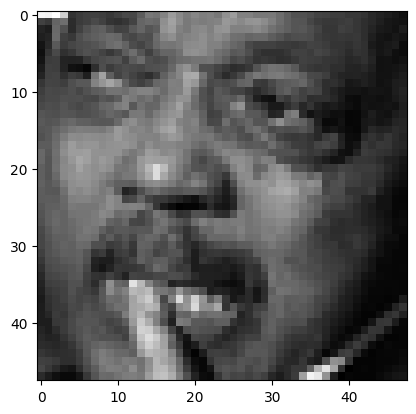

> testing image index: 1923
> true emotion: sad
> predicted emotion: angry
1/1 [==============================] - 0s 20ms/step


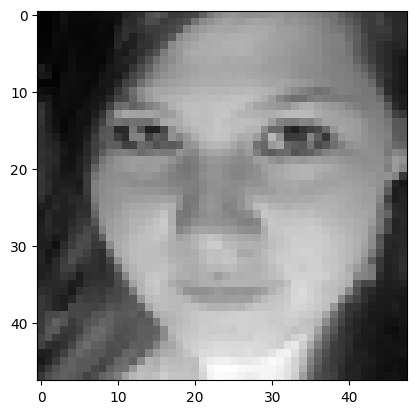

> testing image index: 1682
> true emotion: happy
> predicted emotion: angry
1/1 [==============================] - 0s 20ms/step


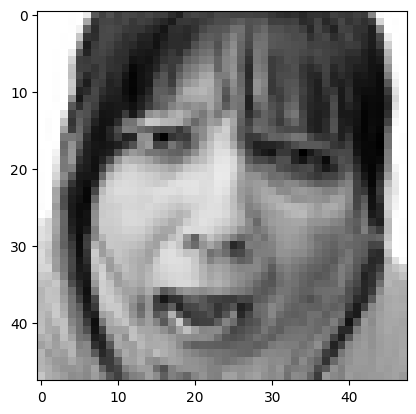

> testing image index: 606
> true emotion: fear
> predicted emotion: angry
1/1 [==============================] - 0s 20ms/step


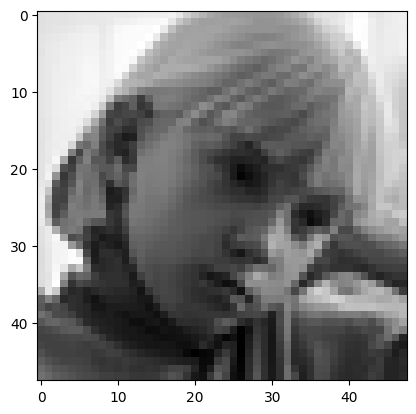

> testing image index: 783
> true emotion: fear
> predicted emotion: sad
1/1 [==============================] - 0s 22ms/step


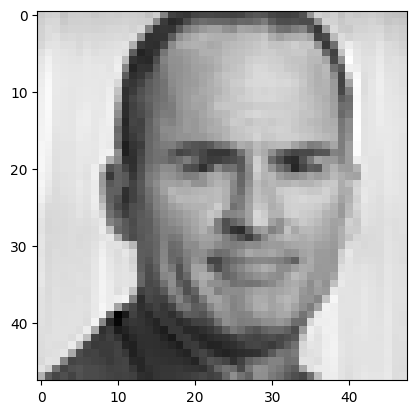

> testing image index: 313
> true emotion: neutral
> predicted emotion: happy
1/1 [==============================] - 0s 20ms/step


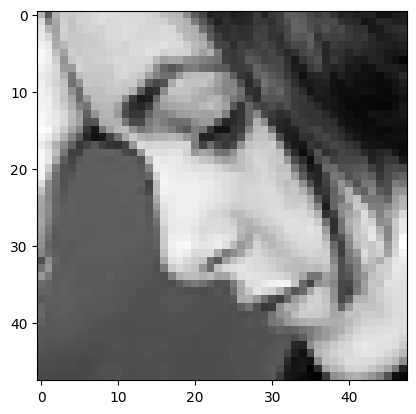

> testing image index: 3309
> true emotion: fear
> predicted emotion: sad
1/1 [==============================] - 0s 20ms/step


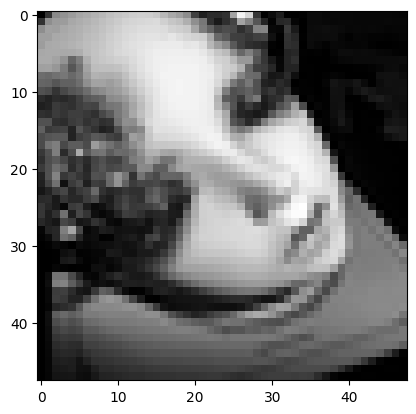

> testing image index: 737
> true emotion: sad
> predicted emotion: happy
1/1 [==============================] - 0s 20ms/step


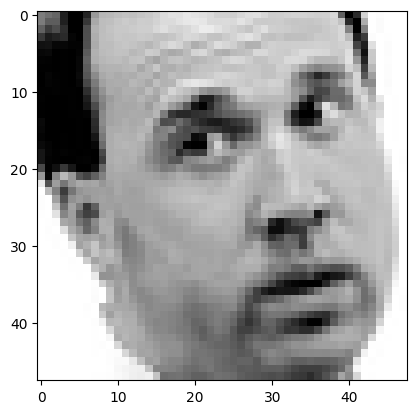

> testing image index: 514
> true emotion: fear
> predicted emotion: neutral
1/1 [==============================] - 0s 19ms/step


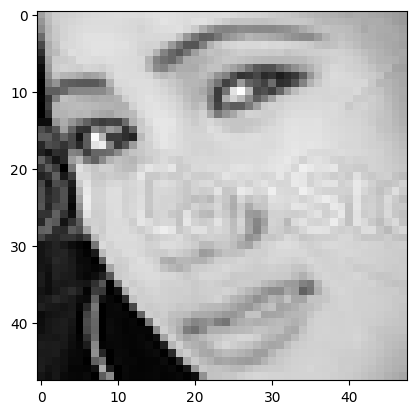

> testing image index: 1
> true emotion: disgust
> predicted emotion: neutral
1/1 [==============================] - 0s 28ms/step


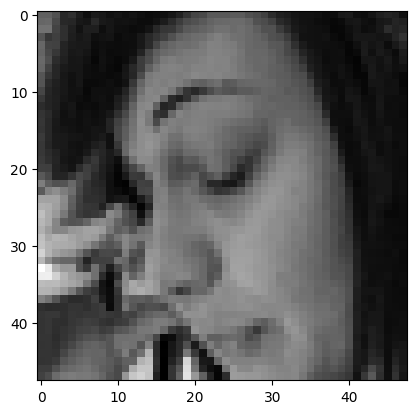

> testing image index: 1976
> true emotion: angry
> predicted emotion: sad


In [173]:
# Get all indices where the predicted label does not match the true label
mismatch_indices = np.where(y_test_pred_label != y_test_label)[0]

# Randomly select 10 indices from the mismatched indices
if len(mismatch_indices) > 10:
    img_to_predict = np.random.choice(mismatch_indices, size=10, replace=False)
else:
    img_to_predict = mismatch_indices
# Loop through each index and use your predict_image function
for indx in img_to_predict:
    predict_image(indx)

In [174]:
from sklearn.metrics import confusion_matrix

In [175]:
cm = confusion_matrix(y_test_label, y_test_pred_label,  normalize='true')
cm

array([[0.50749465, 0.02569593, 0.09635974, 0.06638116, 0.1391863 ,
        0.0235546 , 0.14132762],
       [0.25      , 0.51785714, 0.03571429, 0.05357143, 0.08928571,
        0.        , 0.05357143],
       [0.10887097, 0.01612903, 0.39314516, 0.04637097, 0.23185484,
        0.07862903, 0.125     ],
       [0.02793296, 0.        , 0.02234637, 0.8301676 , 0.03351955,
        0.0122905 , 0.07374302],
       [0.13935681, 0.00765697, 0.10719755, 0.07350689, 0.44257274,
        0.00765697, 0.22205207],
       [0.03855422, 0.00240964, 0.10361446, 0.07228916, 0.01445783,
        0.71566265, 0.05301205],
       [0.07578254, 0.        , 0.06095552, 0.09390445, 0.184514  ,
        0.00658979, 0.57825371]])

In [176]:
import seaborn as sn

<Axes: >

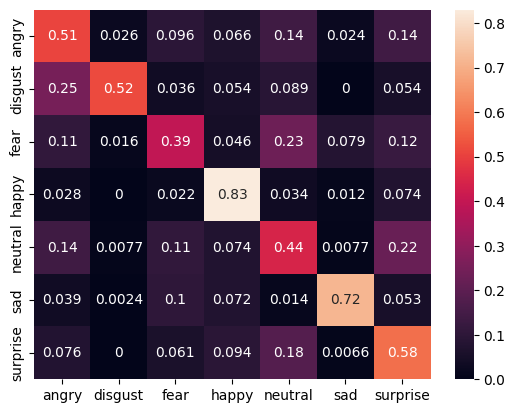

In [177]:
sn.heatmap(cm, annot=True,
           xticklabels=emotion_names, yticklabels=emotion_names)

In [178]:
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if isinstance(layer, Conv2D):
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=self.model.inputs,
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

1/1 [==============================] - 0s 27ms/step


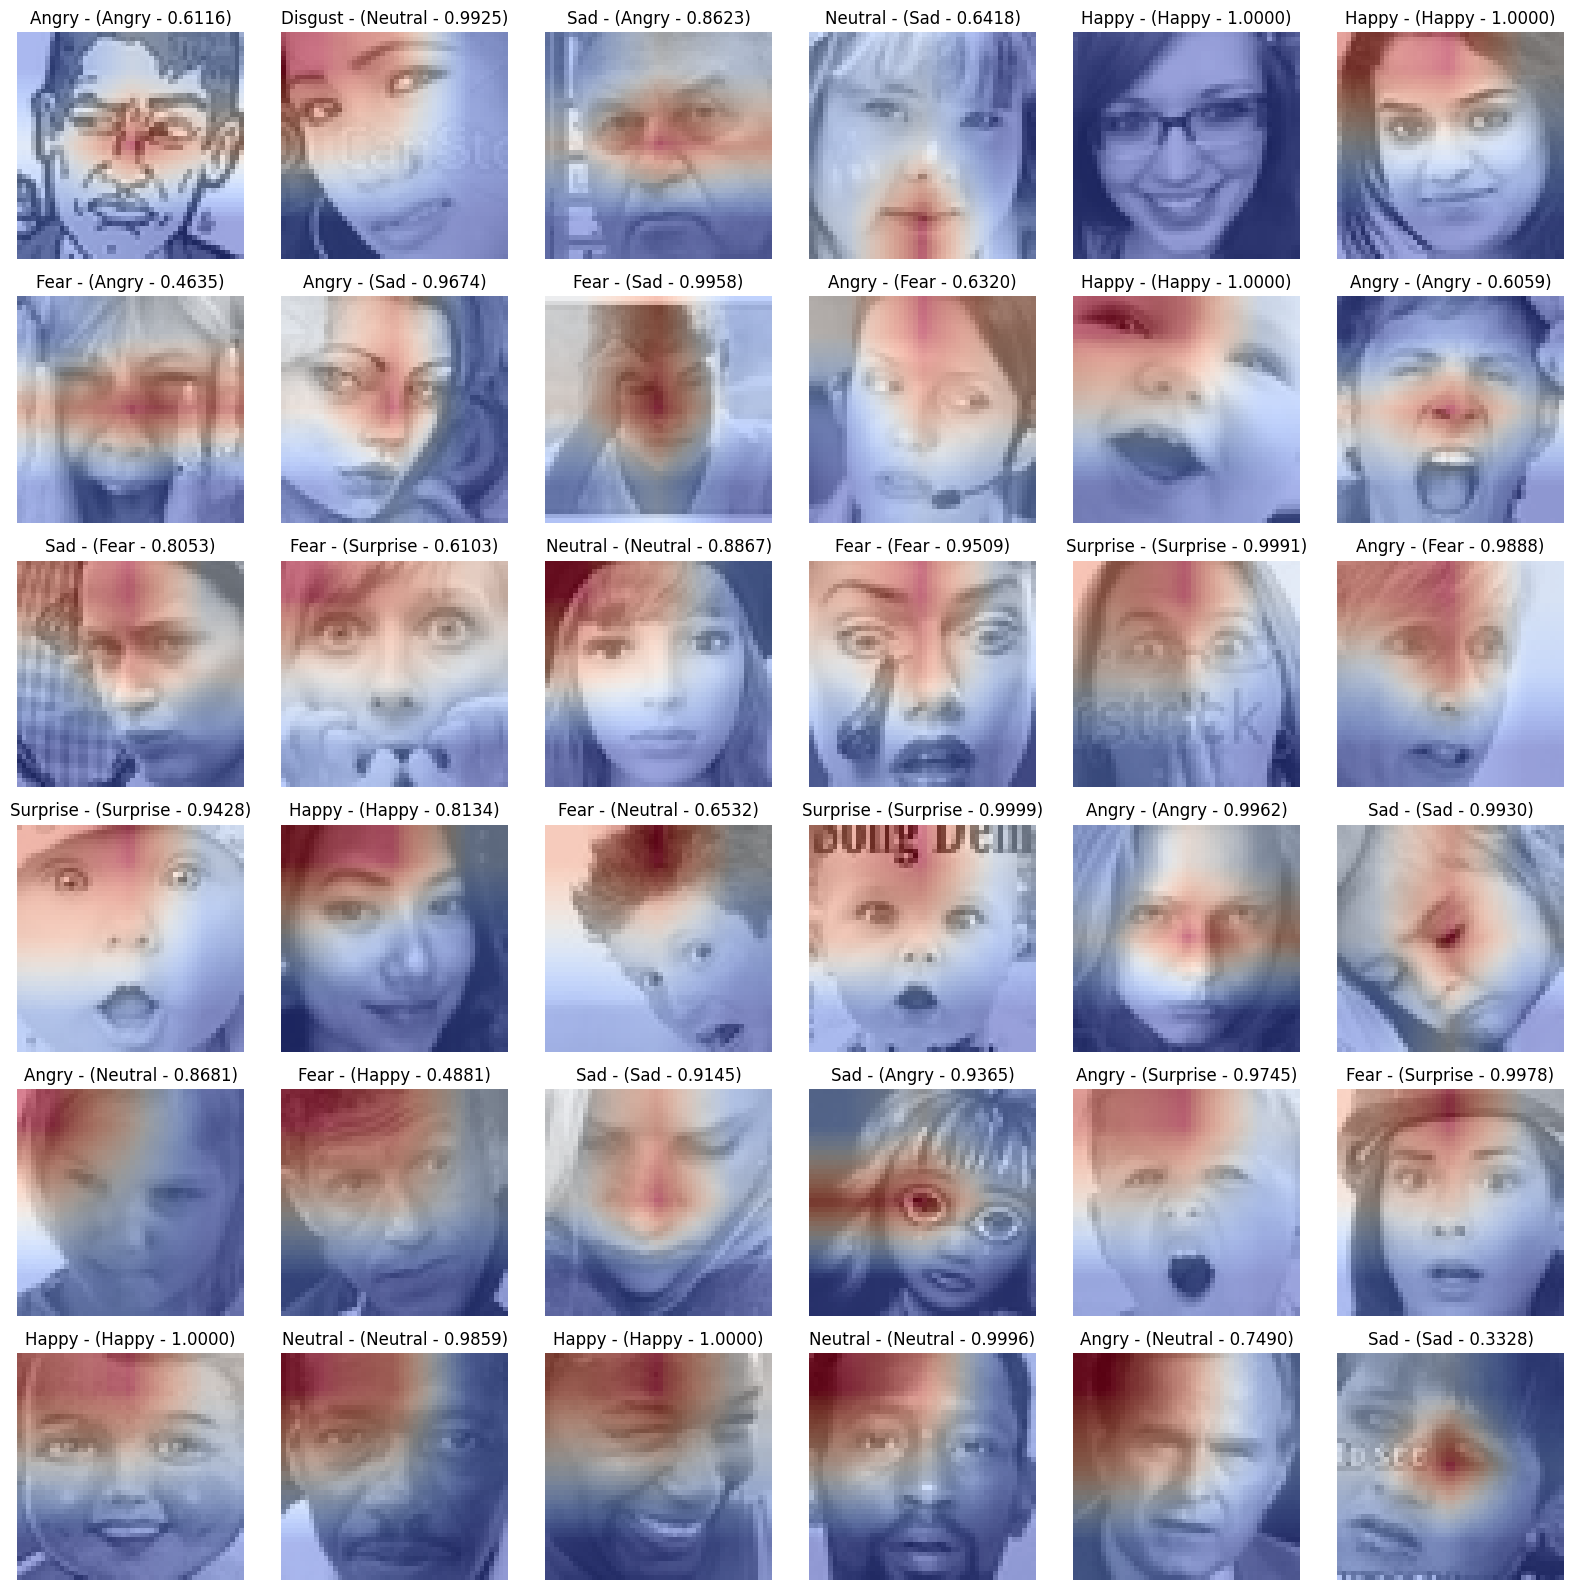

In [179]:
plt.figure(figsize=[16,16])
for i in range(36):
    img = x_testing[i,:,:,0]
    p_dist = model.predict(img.reshape(1,48,48,1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    cam = GradCAM(model, k)
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))

    plt.subplot(6,6,i+1)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='coolwarm')
    plt.title(f'{emotions[y_test_label[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [180]:
!jupyter nbconvert "/content/drive/MyDrive/Colab Notebooks/Bản sao của baseline1.ipynb" --to html

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Bản sao của baseline1.ipynb to html
[NbConvertApp] Writing 1327001 bytes to /content/drive/MyDrive/Colab Notebooks/Bản sao của baseline1.html
